In [434]:
from scipy import signal
import NNControlled1D.forwardconduction as fc
import NNControlled1D.PIDivmech as PID

import sys, getopt
import math
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
import yaml
from tensorflow import keras

In [435]:
def externalforce( i, wave='def'):
    offset, mag, freq = -20, 5, math.pi / 20
    if wave == 'def':
        offset, mag, t = 0, -20, i/500
        sig = np.sin(np.pi/2 + 2 * np.pi * t)
        Too = 0.5*(1 - signal.square(2 * np.pi * 30 * t, duty=(sig + 1)/2))
    elif wave == 'constant':
        Too = 0
    elif wave == 'cos':
        Too = 0.5*(1 - math.cos(i*freq))
    elif wave == 'square':
        Too = 0.5*(1 - signal.square( i*freq ))
    elif wave == 'triangle':
        Too = signal.sawtooth( i*freq, 0.5 )
    else:
        print(wave)
        raise Exception("bad waveform")
    return Bi * (offset + mag * Too)


Bi, Fo = 1.4, .01
model = fc.X23_gToo_I( Bi, Fo, M=100 )
pid = PID.PID( 100, 20, 0, setpoint=0.0 )
Q = pid.update( 0.0 )
print(Q)
ts, y_Qs, y_Ts, y_Es, y_Hs, stops = [], [], [], [], [], []

data_points = 1000
# wave_forms = ['def','triangle','constant','cos','square']
wave_forms = ['def','triangle', 'constant', 'cos']
for wave in wave_forms:
    for i in range(data_points):
        H = externalforce(i, wave)
        v = model.getNextTemp(Q, H)
        y_Qs.append( Q ); y_Ts.append( v[0] ); y_Es.append( v[1] ); y_Hs.append( H/Bi ); Q = pid.update( v[0] )
ts = list(range(len(wave_forms) * data_points))

# Kp = 100
# Ki = 100
# Kd = 0
0.0


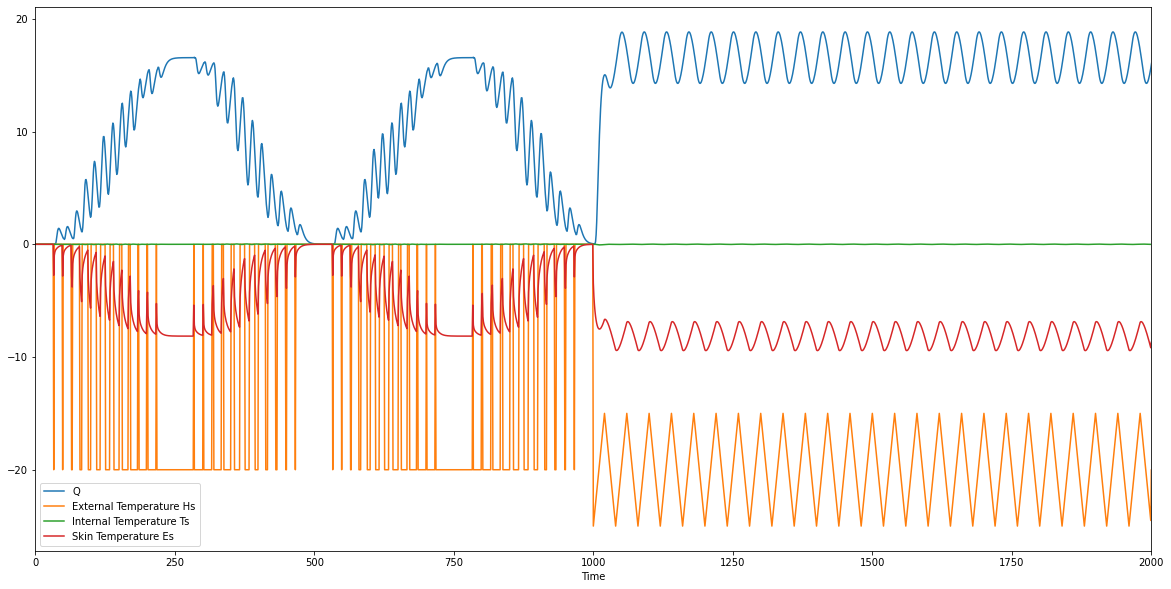

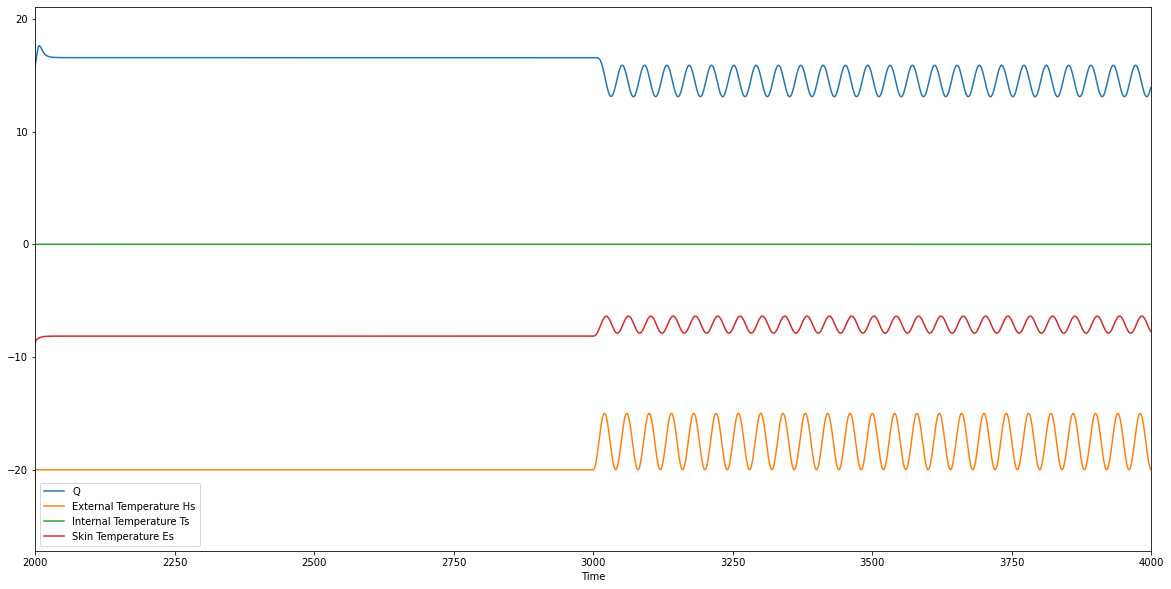

In [436]:
plt.figure(figsize=(20,10))
plt.plot(ts, y_Qs, label= "Q")
plt.plot(ts, y_Hs, label= "External Temperature Hs")
plt.plot(ts, y_Ts, label= "Internal Temperature Ts")
plt.plot(ts, y_Es, label= "Skin Temperature Es")
plt.xlabel('Time')
plt.legend()
plt.xlim(0,2000)
plt.savefig('training_data.png')
plt.show()
plt.close()

plt.figure(figsize=(20,10))
plt.plot(ts, y_Qs, label= "Q")
plt.plot(ts, y_Hs, label= "External Temperature Hs")
plt.plot(ts, y_Ts, label= "Internal Temperature Ts")
plt.plot(ts, y_Es, label= "Skin Temperature Es")
plt.xlabel('Time')
plt.legend()
plt.xlim(2000,4000)
plt.savefig('test_data.png')

In [437]:
def convert_to_sequence(in_array, length):
    return np.array( [ np.array(in_array[i:j]) if j!=0 else np.array(in_array[i:]) for i,j in zip(range(length),range(-length+1,1)) ] ).T
def add_differential_terms(in_array, integral=True, differ=True):
    if integral and differ:
        int = np.array([np.sum(in_array[:,i:i+2],axis=1) for i in range(length-1)]).T
        der = (in_array[:,-1] - in_array[:,-2]).reshape(in_array.shape[0],1)
        in_array = np.append(in_array, int, 1)
        return np.append(in_array, der, 1)

length = 14
lstm = False
ipt = convert_to_sequence(y_Ts, length)
ipt = add_differential_terms(ipt)
seq = convert_to_sequence(y_Es, length)
ipt = np.append(seq, ipt, 1)[:-1,:]

if lstm:
    ipt = ipt.reshape(ipt.shape[0],1,ipt.shape[1])
opt = np.array( [y_Qs[length:]] ).T
# ipt = ipt.reshape(ipt.shape[0],ipt.shape[1],1)
print('input shape: {} , output shape: {}'.format(ipt.shape, opt.shape))

prop = 3/5
pointx, pointy = round(ipt.shape[0]*prop), round(opt.shape[0]*prop)
trainX, testX, trainy, testy = ipt[:pointx], ipt[pointx:], opt[:pointy], opt[pointy:]

input shape: (3986, 42) , output shape: (3986, 1)


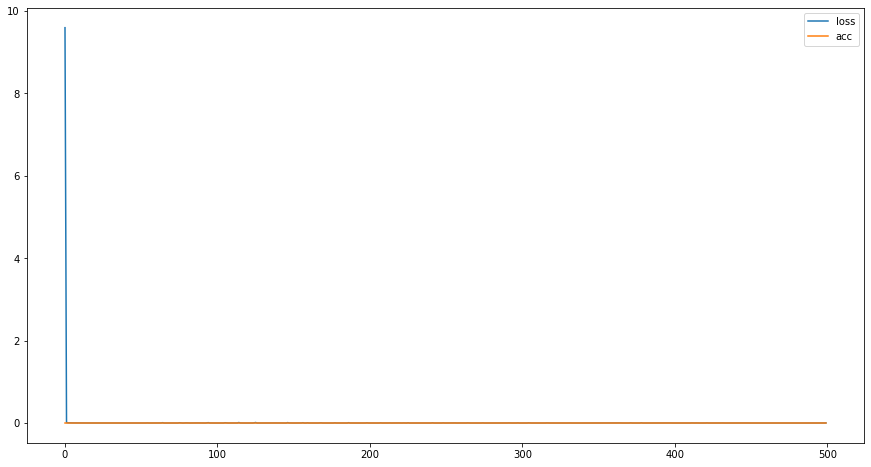

In [438]:
act_func = "relu"
model = keras.Sequential()
model.add(keras.Input(shape=(3*length)))
# model.add(keras.layers.Conv1D(25, 3))
model.add(keras.layers.Dense(128, activation=act_func))
model.add(keras.layers.Dense(128, activation=act_func))
# model.add(keras.layers.Dense(256, activation=act_func))
# model.add(keras.layers.Dense(20, activation=act_func))
# model.add(keras.layers.LSTM(10))
model.add(keras.layers.Dense(1))

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mean_squared_error",
    metrics=["accuracy"],
)
ipt
history = model.fit(trainX, trainy, shuffle=True, epochs=500, verbose=0)
plt.figure(figsize=(15,8))
plt.plot( history.epoch, history.history['loss'], label='loss')
plt.plot( history.epoch, history.history['accuracy'] , label= 'acc')
plt.legend()

In [439]:
def sequential_predict(model, x_start, n_predict = 500):
    fc_model = fc.X23_gToo_I(Bi, Fo, M=100)
    new_x = np.zeros(x_start.shape)
    
    Q = model.predict(x_start)[0][0]
    v = fc_model.getNextTemp(Q, y_Hs[length+start_point])
    new_x[0,:length-1], new_x[0,length-1] = x_start[0,1:length], v[1]
    new_x[0,length:2*length-1], new_x[0,2*length-1] = x_start[0,length:2*length-1], v[0]
    new_x[0,3*length-1], new_x[0,2*length:3*length-1] = (new_x[0,2*length-1] - new_x[0,2*length-2]), np.array([np.sum(new_x[0,i:i+2]) for i in range(length,2*length-1)])

    results, T_core, T_skin = [Q], [v[0]], [v[1]]
    for j in range(1, n_predict):
        Q = model.predict(new_x)[0][0]
        v = fc_model.getNextTemp(Q, y_Hs[length+j+start_point])
        new_x[0,:length-1], new_x[0,length-1] = new_x[0,1:length], v[1]
        new_x[0,length:2*length-1], new_x[0,2*length-1] = new_x[0,length:2*length-1], v[0]
        new_x[0,3*length-1], new_x[0,2*length:3*length-1] = (new_x[0,2*length-1] - new_x[0,2*length-2]), np.array([np.sum(new_x[0,i:i+2]) for i in range(length,2*length-1)])
        T_core.append( v[0] ); results.append( Q ); T_skin.append(v[1])
    return results, T_core, T_skin

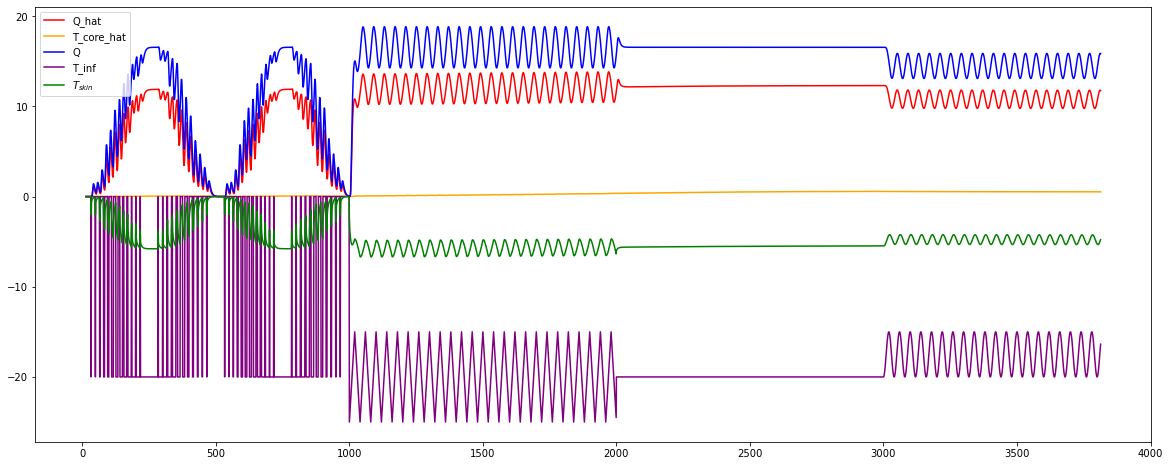

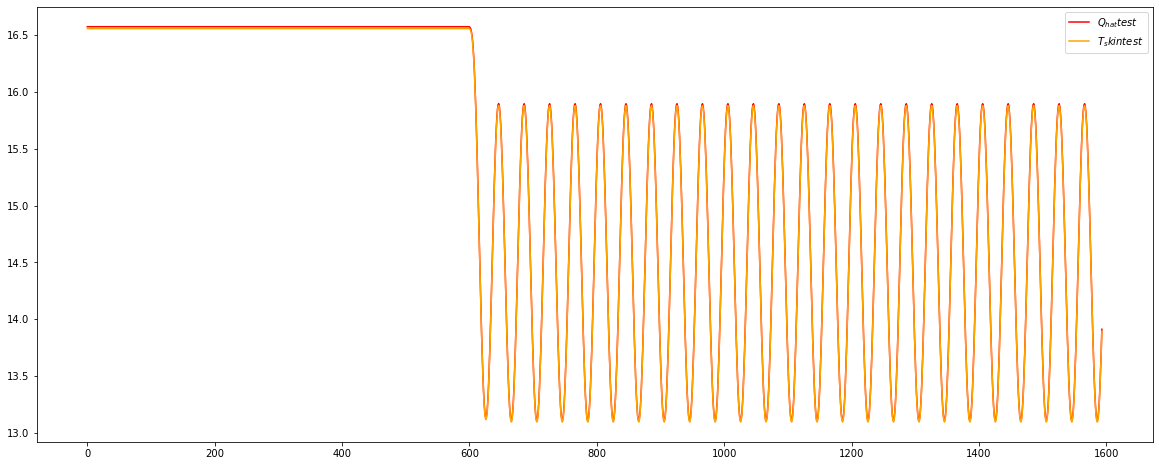

In [445]:
start_point = 0
size = 3800
Q_hat, core_hat, skin_hat = sequential_predict(model, ipt[start_point:(start_point+1)], size)

t = list(range(length+start_point,start_point+size+length))
plt.figure(figsize=(20,8))
plt.plot(t, Q_hat, label='Q_hat', color='red')
plt.plot(t, core_hat, label='T_core_hat', color='orange')
plt.plot(t, y_Qs[length+start_point:(length+start_point+size)], label='Q', color='blue')
plt.plot(t, y_Hs[length+start_point:(length+start_point+size)], label='T_inf', color='purple')
plt.plot(t, skin_hat, label='$T_{skin}$', color='green')
plt.legend()
plt.savefig("train_seq_predict.png")
plt.show()

testPrediction = model.predict(testX)[:,0]
t = list(range(len(testPrediction)))
plt.figure(figsize=(20,8))
plt.plot(t, testPrediction, label='$Q_{hat} test$', color='red')
plt.plot(t, testy[:,0], label='$T_skin test$', color='orange')
# plt.plot(y_Qs[length+start_point:(length+start_point+1000)], label='Q', color='blue')
# plt.plot(y_Hs[length+start_point:(length+start_point+1000)], label='T_inf', color='purple')
# plt.plot(skin_hat, label='$T_{skin}$', color='green')
plt.legend()

Text(0, 0.5, 'importance')

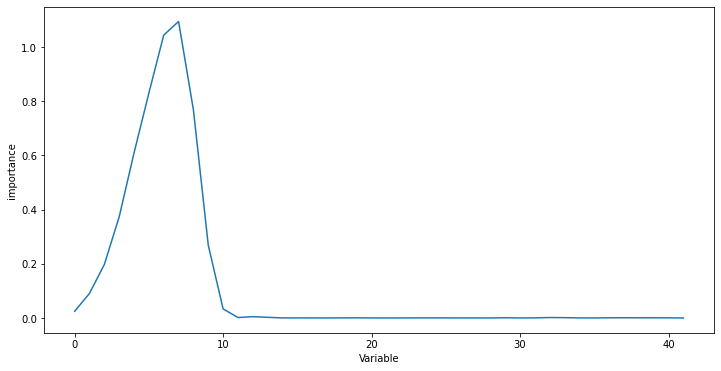

In [444]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, ipt, opt, scoring='neg_mean_squared_error', n_repeats=10)
plt.figure(figsize=(12,6))
plt.plot(result.importances_mean)
plt.xlabel('Variable')
plt.ylabel("importance")

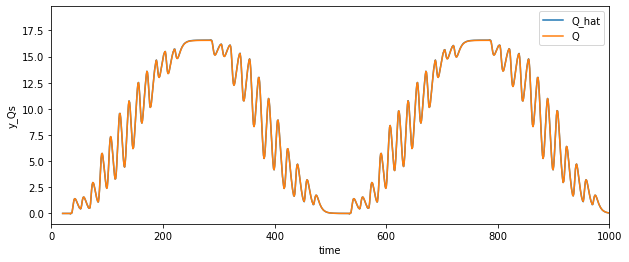

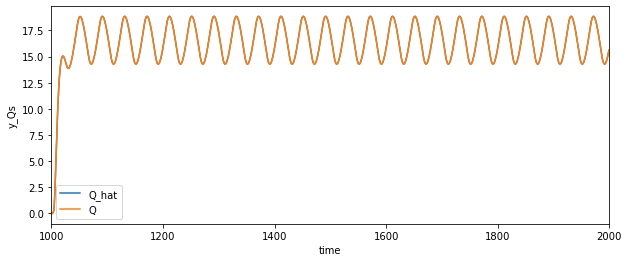

In [325]:
for i in range(1,3):
    plt.figure(figsize=(10,4))
    plt.ylabel("y_Qs")
    plt.xlabel("time")
    plt.plot(ts[(length):(data_points*len(wave_forms)+length)],model.predict(ipt), label="Q_hat")
    plt.plot(ts[(length):(data_points*len(wave_forms)+length)],y_Qs[(length):(ipt.shape[0]+length)],label='Q')
    plt.xlim((i-1)*1000,i*1000)
    plt.legend()
    plt.savefig('training.png')
    plt.show()